In [ ]:
import os
import PIL

from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage import measure

DIR = "/kaggle/input/chest-xray-masks-and-labels/data/"

lung_image_paths = glob(os.path.join(DIR,"Lung Segmentation/CXR_png/*.png"))
mask_image_paths = glob(os.path.join(DIR,"Lung Segmentation/masks/*.png"))

related_paths = defaultdict(list)

for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

paths_df = pd.DataFrame.from_dict(related_paths)

In [ ]:
DIR = "/kaggle/input/covid19-radiography-database/"

covid_image_paths = glob(os.path.join(DIR,"COVID/*.png"))

related_paths = defaultdict(list)

for covid_path in covid_image_paths:
    covid_match = re.search("COVID/(.*)\.png$", covid_path)
    if covid_match:
        covid_name = covid_match.group(1)
        related_paths["covid_path"].append(covid_path)

paths_dfc = pd.DataFrame.from_dict(related_paths)
print(paths_dfc)

Empty DataFrame
Columns: []
Index: []


/kaggle/input/chest-xray-masks-and-labels/data/Lung Segmentation/CXR_png/CHNCXR_0629_1.png


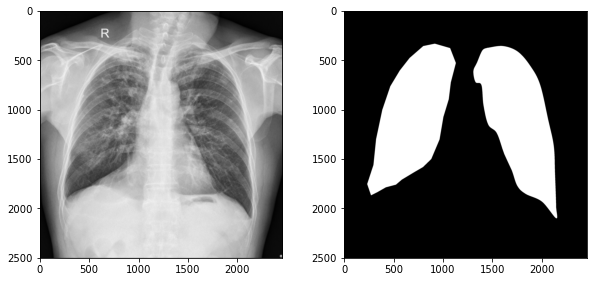

In [ ]:
xray_num = 5
img_path = paths_df["image_path"][xray_num]
mask_path = paths_df["mask_path"][xray_num]

img = PIL.Image.open(img_path)
mask = PIL.Image.open(mask_path)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, cmap = "gray")

print(img_path)

In [ ]:
print(img_path)

/kaggle/input/chest-xray-masks-and-labels/data/Lung Segmentation/CXR_png/CHNCXR_0629_1.png


In [ ]:
xray_num = 5
covid_path = paths_dfc["covid_path"][xray_num]

print(covid_path)
img = PIL.Image.open(covid_path)


fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(1,1,1)
ax1.imshow(img, cmap = "gray")


KeyError: 'covid_path'

In [ ]:
from tqdm import tqdm
import cv2
def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
      # img_array.append(resized_image)

    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])
        # mask_array.append(resized_image)

    return img_array, mask_array

img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (256,256), color_mode = "gray")


In [ ]:
from tqdm import tqdm
import cv2
def prepare_train_test1(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "gray"):
    covid_array = list()


    for covid_path in tqdm(paths_dfc.covid_path):
        resized_image = cv2.resize(cv2.imread(covid_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            covid_array.append(resized_image[:,:,0])
        #elif color_mode == "rgb":
            #covid_array.append(resized_image[:,:,:])
      # img_array.append(resized_image)

    return covid_array

covid_array = prepare_train_test1(df = paths_dfc, resize_shape = (256,256), color_mode = "gray")

In [ ]:
from sklearn.model_selection import train_test_split
img_train, img_test, mask_train, mask_test = train_test_split(img_array, mask_array, test_size = 0.2, random_state= 42)

img_side_size = 256
img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size)
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size)

In [ ]:
#img_side_size = 256
#covid_array = np.array(covid_array).reshape(len(covid_array), img_side_size, img_side_size, 1)



In [ ]:
### U-net

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
EPOCHS = 10
model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(lr=5*1e-4), loss="binary_crossentropy", \
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png')

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='loss', #verbose=1,
                             save_best_only=True, #mode='min',
                             save_weights_only = True)


early = EarlyStopping(monitor="loss",
                      #mode="min",
                      patience=10)
callbacks_list = [checkpoint, early]

In [ ]:
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

history = model.fit(x = img_train,
                    y = mask_train,
                    validation_data = (img_test, mask_test),
                    epochs = 30,
                    batch_size = 16,
                   callbacks = callbacks_list)
model.save('my_model.h5')

In [ ]:
model.save('my_model.h5')

In [ ]:
def test_on_image(model, img_array, img_num, img_side_size=256):

    pred = model.predict(img_array[img_num].reshape(1, img_side_size, img_side_size, 1))
    pred[pred > 0.5] = 1.0
    pred[pred < 0.5] = 0.0
    fig = plt.figure(figsize=(15, 10))

    plt.subplot(1, 4, 1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap="Blues")
    plt.title("Prediction")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap="Blues")
    plt.title("Actual Mask")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap="Blues", alpha=0.5)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap="PuBu", alpha=0.3)
    plt.title("Overlay")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    return pred

def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union == 0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

IMG_NUM = 3
prediction = test_on_image(model, img_array=img_test, img_num=IMG_NUM, img_side_size=256)
dice_coef_test(y_true=mask_test[IMG_NUM], y_pred=prediction)


In [ ]:
def get_metrics(history):
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(history.history["loss"], label="training loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("Binary Cross-Entropy")

    plt.subplot(2, 2, 2)
    plt.plot(history.history["dice_coef"], label="training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label="validation dice coefficient")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("Dice Coefficient")

get_metrics(history=history)


In [ ]:

def test_on_image1(model, img_array, img_num, img_side_size = 256):

    pred = model.predict(covid_array[img_num].reshape(1,img_side_size,img_side_size))
    pred[pred>0.5] = 1
    pred[pred<0.5] = 0
    pred1 = pred.reshape(img_side_size, img_side_size)


    return pred1



In [ ]:
masksc = list()
for i in tqdm(range(len(covid_array))):
    prediction = test_on_image1(model, img_array = covid_array, img_num = i, img_side_size = 256)
    masksc.append(prediction)

In [ ]:
masksc

In [ ]:
teste = np.copy(masksc)
mask = list(teste)

In [ ]:
teste1 = np.copy(mask)
linha, coluna = teste[0].shape
testebin = []

for tImg in teste:
    pixel = tImg[linha-1, 1]
    for i in range(linha):
        for j in range(coluna):
            if tImg[i,j] != pixel:
                    tImg[i,j] = 1
            else:
                tImg[i,j] = 0
    testebin.append(tImg)

In [ ]:
fig, aux = plt.subplots(1,9, figsize=(30,10))
for i in range(0,9):
    aux[i].imshow(masksc[i], cmap='gray')

In [ ]:
largestRegion = []

for kImg in testebin:

    region = np.zeros(kImg.shape)

    label_image = measure.label(kImg, connectivity=kImg.ndim)
    num_labels = np.unique(label_image)

    for indice in num_labels:
        props = measure.regionprops(label_image)

        area = [reg.area for reg in props]
        largest_label_ind = np.argmax(area)
        largest_label = props[largest_label_ind].label

        region[label_image == largest_label] = indice

    for i in range(region.shape[0]):
        for j in range(region.shape[1]):
            if region[i,j] != 0:
                region[i,j] = 1

    largestRegion.append(region)

In [ ]:
multi = list()
for i in tqdm(range(len(covid_array))):
    multi.append(np.multiply(covid_array[i], masksc[i]))

In [ ]:
from pathlib import Path
import numpy as np
from skimage.io import imread,imsave, imread_collection
import matplotlib.pyplot as plt
import glob as g
from skimage import data

base = glob('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/*.png')

In [ ]:
for i in range(len(masksc)):
    filename = Path(base[i]).stem
    imsave('./'+filename+'.png', masksc[i])

In [ ]:
!zip -m images.zip ./*.png

In [ ]:
filters, biases = history.model.layers[1].get_weights()


f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

show_n_filters = 8
n_rows = 2
for i in range(show_n_filters):
    plt.subplot(n_rows,show_n_filters/n_rows,i+1)
    plt.imshow(filters[:,:,:,i].reshape(filters[:,:,:,i].shape[0], filters[:,:,:,i].shape[1]), cmap = "gray")


In [ ]:
filters, biases = history.model.layers[4].get_weights()
filters.shape

In [ ]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:30]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_array[1].reshape(1,256,256,1))

In [ ]:
num = 0
size = 256
plt.imshow(activations[num].reshape(size, size))

In [ ]:
num_activ = 20
num_filters = 8
nrows = 2

plt.figure(figsize=(10, 8))

filter_conv = 0
i = 0

while i < num_filters:
    try:
        if activations[num_activ][:, :, :, filter_conv].sum() > 5:
            plt.subplot(nrows, num_filters // nrows, i + 1)
            plt.imshow(activations[num_activ][:, :, :, filter_conv].reshape(activations[num_activ].shape[1], activations[num_activ].shape[2]), cmap="Blues")
            plt.title("Filter {}".format(filter_conv))
            plt.axis("off")
            i += 1
        filter_conv += 1
    except:
        pass


In [ ]:
activations[2].shape

In [ ]:
dice_coefs = list()
for i in tqdm(range(len(img_test))):
    prediction = test_on_image(model, img_array = img_test, img_num = i, img_side_size = 256)
    dice = dice_coef_test(y_true = mask_test[i], y_pred = prediction)
    dice_coefs.append(dice)

In [ ]:
dice_coefs.median()

In [ ]:
plt.hist(np.array(dice_coefs), bins=50)
print(np.median(np.array(dice_coefs)))
plt.xlabel("Dice Coefficient")
plt.ylabel("Number of Occurrences")
